# Movie Recommendation Systems

Basically, there are two kinds in the recommendation systems. The first is the **Content-Based** recommender, and the second is the **Collaborative Filtering** recommender. In this practice, I will practice to make the former.

## Content-Based Recommender

**Content-based recommender** is the recommending system to rely on the similarity of items when it recommends items to users. For example, when a user likes a specific movie, the system finds and recommends the items which have similar features to the movie the user likes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the Data

Let's read the data. The data is the **MovieLens** Dataset. There are multiple versions of the movie dataset from the MovieLens. The version used in this practice has 9,742 movies.

In [2]:
movies = pd.read_csv('movies.csv')

In [3]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Check the size of the dataset.

In [4]:
movies.shape

(9742, 3)

It has 9,742 movies. Check how many missng values are in each column.

In [5]:
# create a function to create a table showing the numbers of missing values for each feature
def create_missing_df(dataframe):
  
  missing_index = dataframe.columns.tolist() 
  missing = dataframe.isnull().sum().tolist()
  missing_df = pd.DataFrame({'Missing':missing}, index=missing_index)

  return missing_df

In [6]:
create_missing_df(movies)

,Missing
movieId,0
title,0
genres,0


There is no missing value in the data set. 

The values of the column **title** have the format, '**title (year)**'. Since it is more convenient to separate **title** from **year** for the later use, I will separate these two in advance.

In [7]:
# the function to extract titles
def extract_title(title):

  year = title[len(title)-5:len(title)-1]

  # some movies do not have the info about year in the column title. So, we should take care of the case as well.
  if year.isnumeric():
    title_no_year = title[:len(title)-7]
    return title_no_year

  else:
    return title

In [8]:
# the function to extract years
def extract_year(title):

  year = title[len(title)-5:len(title)-1]

  # some movies do not have the info about year in the column title. So, we should take care of the case as well.
  if year.isnumeric():
    return int(year)

  else:
    return np.nan

In [9]:
movies.rename(columns={'title':'title_year'}, inplace=True) # change the column name from title to title_year
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip()) # remove leading and ending whitespaces in title_year
movies['title'] = movies['title_year'].apply(extract_title) # create the column for title
movies['year'] = movies['title_year'].apply(extract_year) # create the column for year

Let's check missing values again.

In [10]:
create_missing_df(movies)

,Missing
movieId,0
title_year,0
genres,0
title,0
year,12


12 movies do not have info about **year**. That's why those movies have missing values in the column **year** when **year** is separated from **title**. **year** is not very critical for this recommendation practice. So, I will let the missing values in **year** remain in the data. 

### Explore the Feature (genres)

The column **genres** is the only feature used for this recommending system. The movies which do not have info about **genres** are unnecessary in this practice. I will drop those movies in the data. 

In [11]:
r,c = movies[movies['genres']=='(no genres listed)'].shape 
print('The number of movies which do not have info about genres:',r)

The number of movies which do not have info about genres: 34


In [12]:
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

Each movie contains multiple genres as follows: 

In [13]:
movies[['title','genres']].head(5)

,title,genres
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,Adventure|Children|Fantasy
2,Grumpier Old Men,Comedy|Romance
3,Waiting to Exhale,Comedy|Drama|Romance
4,Father of the Bride Part II,Comedy


Let's see how many times each genre appears in the data.

In [14]:
# remove '|' in the genres column
movies['genres'] = movies['genres'].str.replace('|',' ')

In [15]:
# count the number of occurences for each genre in the data set
counts = dict()

for i in movies.index:
  for g in movies.loc[i,'genres'].split(' '):
    if g not in counts:
      counts[g] = 1
    else:
      counts[g] = counts[g] + 1

Text(0, 0.5, 'Counts')

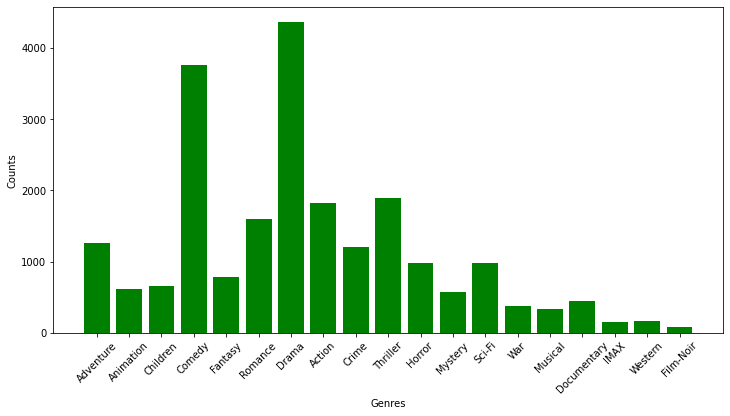

In [16]:
plt.figure(figsize=(12,6))
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

Drama and Comedy are the most in the data set. About half of the movies in the data are categorized into Drama or Comedy. 

### Term Frequency and Inverse Document Frequency (tf-idf)

The **TfidVectorizer()** class from the **sklearn.feature_extraction.text** library helps us to calculate the **tf-idf** scores for each genre in each movie.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')

In [19]:
tfidf_vector = TfidfVectorizer(stop_words='english') # create an object for TfidfVectorizer
tfidf_matrix = tfidf_vector.fit_transform(movies['genres']) # apply the object to the genres column

The list and order of genres used in the vectorization are as follows:

In [20]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'imax'), (11, 'musical'), (12, 'mystery'), (13, 'noir'), (14, 'romance'), (15, 'scifi'), (16, 'thriller'), (17, 'war'), (18, 'western')]


Let's see the examples of the vectorization for the first 5 movies.

In [21]:
print(tfidf_matrix[:5])

  (0, 8)	0.48301747178653426
  (0, 4)	0.26738777563975086
  (0, 3)	0.5048957307474672
  (0, 2)	0.5162876752057701
  (0, 1)	0.41680359510322523
  (1, 8)	0.5936766667075072
  (1, 3)	0.6205672299106341
  (1, 1)	0.5122932056626417
  (2, 14)	0.8211549883098352
  (2, 4)	0.5707052524498741
  (3, 7)	0.46621627821471856
  (3, 14)	0.7264518207332316
  (3, 4)	0.5048862585582906
  (4, 4)	1.0


The first argument in the index above is the same as the index in the dataframe **movies** (**Not** movieId), and the second argument represents the index number of **genres**. The numbers in the second argument correspond to the index number in the previous code output. [(0, 'action'), (1, 'adventure'), (3, 'children'),...] For example, **(0,8) = 0.4830** means that movie index = 0 (**Toy Story**), genre index = 8 (**'fantasy'**), and the tf-idf score = 0.4830. The tf-idf score of **comedy** for **Toy Story** is **(0,4)=0.2674**. As mentioned earlier, the comedy has lower score than fantasy because it is very common genre in the whole data set, and is considered less important in defining the genre of the movie.

In [22]:
tfidf_matrix.shape

(9708, 19)

In [23]:
# the first row vector of tfidf_matrix (Toy Story)
tfidf_matrix.todense()[0]

matrix([[0.        , 0.4168036 , 0.51628768, 0.50489573, 0.26738778,
         0.        , 0.        , 0.        , 0.48301747, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]])

Next, let's caculate the similarity between two movies using the **tf-idf matrix**. The **cosine similarity** is used to calculate the similarity, and **linear_kernel()** class is used to calculate this.

In [24]:
from sklearn.metrics.pairwise import linear_kernel

In [25]:
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix) # create the cosine similarity matrix
print(sim_matrix)

[[1.         0.8136036  0.15259961 ... 0.         0.42114166 0.26738778]
 [0.8136036  1.         0.         ... 0.         0.         0.        ]
 [0.15259961 0.         1.         ... 0.         0.         0.57070525]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.42114166 0.         0.         ... 0.         1.         0.        ]
 [0.26738778 0.         0.57070525 ... 0.         0.         1.        ]]


**sim_matrix**$_{ij}$ is the similarity score between movie $i$ and movie $j$.Therefore, the diagonal elements in the matrix represent the similarity scores of a movie with itself, and therefore, the value should be 1. By the definition of the matrix, **sim_matrix**$_{ij}$ = **sim_matrix**$_{ji}$. 

### Make the Recommendation Engine 

When we use movie recommendation system, we type the title of the movie. However, the **sim_matrix** is based on the index of each movie. Therefore, we need to convert movie title into movie index and movie index into movie title. Let's create functions which operate those functions.

In [26]:
# the function to convert from index to title_year
def get_title_year_from_index(index):

  return movies[movies.index == index]['title_year'].values[0]

# the function to convert from title to index
def get_index_from_title(title):

  return movies[movies.title == title].index.values[0]

#### Apply Levenshtein Distance for 'Did you mean?' Algorithm

We often misspell titles of movies when we use movie recommending system. When we use *Google* to search movies, if we misspell the title of the movie, we see that *Google* asks us, *'Did you mean...?'*. Let's create the similar function to correct misspelled title in order to make the system work easily. I apply **Levenshtein Distance** in order to implement *'Did you mean...?'* algorithm. **fuzzywuzzy** library in Python provides **fuzz** class for the **Levenshtein Distance**.

In [27]:
!pip install fuzzywuzzy

In [28]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [29]:
# create a function to find the closest title
def matching_score(a,b):

  return fuzz.ratio(a,b)

**fuzz.ratio(a,b)** calculates the Levenshtein Distance between **a** and **b**, and return the score for the distance. If the two words, **a** and **b**, are exactly the same, the score becomes 100. As the distance between the words increases, the score falls. 

In [31]:
# a function to convert index to title
def get_title_from_index(index):

  return movies[movies.index == index]['title'].values[0]

In [33]:
# the function to return the most similar title to the words a user types
def find_closest_title(title):

  leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
  sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
  closest_title = get_title_from_index(sorted_leven_scores[0][0])
  distance_score = sorted_leven_scores[0][1]

  return closest_title, distance_score

The function **find_closest_title()** is supposed to return the most similar title to the words a user types. Without this, the recommending system only works when the movie title a user types is exactly the same as the movie title the system has.  

#### Create the Recommending System

In [34]:
def contents_based_recommender(movie_user_likes, how_many):

  closest_title, distance_score = find_closest_title(movie_user_likes)

  if distance_score == 100:

    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) # remove the typed movie itself

    print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    for i,s in similar_movies[:how_many]: 
      print(get_title_year_from_index(i))
    

  else:
    print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')

    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))

    print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    for i,s in similar_movies[:how_many]:
      print(get_title_year_from_index(i))

The recommending system returns the list of movies similar to the movie a user likes. It finds and recommends movies even if the user misspell the tile of the movie he or she likes. If the user misspell the title, the system finds the most similar title to the words the user types and recommends movies based on the movie it found alternatively.  

#### Test the System

Let's find similar movies to **'Monsters, Inc.'**. Set the number of the recommended movies as 20. 

In [35]:
contents_based_recommender('Monsters, Inc.', 20)

Here's the list of movies similar to Monsters, Inc..

Toy Story (1995)
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)
Wild, The (2006)
Shrek the Third (2007)
Tale of Despereaux, The (2008)
Asterix and the Vikings (Astérix et les Vikings) (2006)
Turbo (2013)
The Good Dinosaur (2015)
Moana (2016)
Inside Out (2015)
Black Cauldron, The (1985)
Lord of the Rings, The (1978)
We're Back! A Dinosaur's Story (1993)
Atlantis: The Lost Empire (2001)
Land Before Time, The (1988)
Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)
Sinbad: Legend of the Seven Seas (2003)


The recommending system found pretty similar movies to the movie I chose.

Let's see what will happen if we type the title in a wrong way.

In [36]:
contents_based_recommender('Monster Incorporation.', 20)

Did you mean Monsters, Inc.? 

Here's the list of movies similar to Monsters, Inc..

Toy Story (1995)
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)
Wild, The (2006)
Shrek the Third (2007)
Tale of Despereaux, The (2008)
Asterix and the Vikings (Astérix et les Vikings) (2006)
Turbo (2013)
The Good Dinosaur (2015)
Moana (2016)
Inside Out (2015)
Black Cauldron, The (1985)
Lord of the Rings, The (1978)
We're Back! A Dinosaur's Story (1993)
Atlantis: The Lost Empire (2001)
Land Before Time, The (1988)
Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)
Sinbad: Legend of the Seven Seas (2003)


Even if the title I typed was not the same as what the data contains, it found the movie correctly and recommended the list well. 